<a href="https://colab.research.google.com/github/ItsKarma1/FireDetector/blob/master/2017FYP4%20(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linking Colab to Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Importing TensorFlow 2.1**

In [3]:
pip uninstall tensorflow

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0


In [4]:
pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 3.9MB 55.6MB/s 
     |████████████████████████████████| 450kB 55.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1c8fbcdac70b02cb5d5049d760acf3be33c88167ead48231ed466b2ab2e3107e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [5]:
import tensorflow as tf

#  **Model Architecture**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(8, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # CONV => RELU => POOL
		model.add(SeparableConv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(96, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

# **Path to Datasets and Classes**

In [7]:
Fire_Path = '/content/drive/My Drive/Colab Notebooks/Fireset'
NonFire_Path = '/content/drive/My Drive/spatial_envelope_256x256_static_8outdoorcategories'

In [8]:
# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.80
TEST_SPLIT = 0.20

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 0.01
BATCH_SIZE = 64
NUM_EPOCHS = 60
SAMPLE_SIZE = 50

# **Loading Data**

In [9]:
import matplotlib                   # PLOTTING LIBRARY
matplotlib.use("Agg")               # AGG renders the plots at the backend
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.optimizers import SGD  # Stochastic Gradient Descent Optimizer
from tensorflow.keras.utils import to_categorical # Conversion into Binary Class Matrices
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))

		# add the image to the data lists
		data.append(image)
  # return the data list as a NumPy array
	return np.array(data, dtype="float32")
# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset( Fire_Path)
print("[INFO] Fire set is loaded")
nonFireData = load_dataset( NonFire_Path)
print("[INFO] Non Fire set is loaded")
print("[INFO] Completed")

[INFO] loading data...
[INFO] Fire set is loaded
[INFO] Non Fire set is loaded
[INFO] Completed


In [10]:
print(fireData.shape)
print(nonFireData.shape)

(2236, 128, 128, 3)
(2693, 128, 128, 3)


In [11]:
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])

# **Exploring the Data**

In [12]:
data = data/255
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [13]:
print(data.shape)
print(labels.shape)
print(classTotals)

(4929, 128, 128, 3)
(4929, 2)
[2693. 2236.]


In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size= TEST_SPLIT, random_state=42)

In [15]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3943, 128, 128, 3)
(3943, 2)
(986, 128, 128, 3)
(986, 2)


# **Exploring the Training Set** 

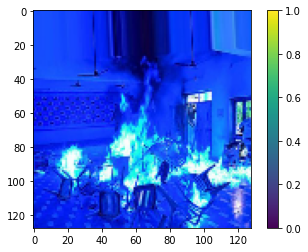

In [16]:
%matplotlib inline
plt.figure()
plt.imshow(trainX[14])
plt.colorbar()
plt.grid(False)
plt.show()

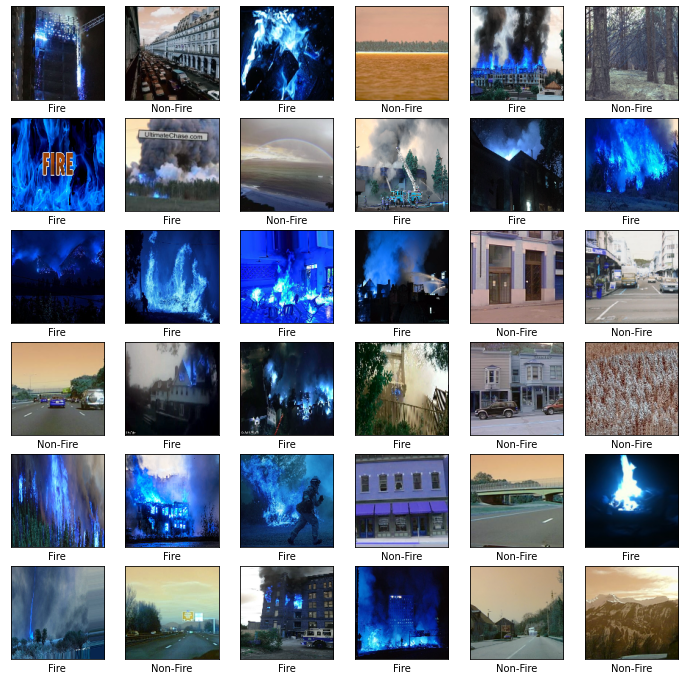

In [17]:
plt.figure(figsize=(12,12))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    if trainY[i][0] == 1:
      plt.xlabel("Non-Fire")
    else:
      plt.xlabel("Fire")

plt.show()

# **Training the Model**

In [18]:
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr= INIT_LR, momentum=0.9,
	decay= INIT_LR /  NUM_EPOCHS)
model = FireDetectionNet.build(width=128, height=128, depth=3,
	classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size= BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] //  BATCH_SIZE,
	epochs= NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size= BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names= CLASSES))

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format( MODEL_PATH))
#model.save( MODEL_PATH)

[INFO] compiling model...
[INFO] training network...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 61 steps, validate on 986 samples
Epoch 1/60
61/61 [==============================] - 22s 364ms/step - loss: 0.5943 - accuracy: 0.7435 - val_loss: 0.7026 - val_accuracy: 0.5639
Epoch 2/60
61/61 [==============================] - 16s 258ms/step - loss: 0.4160 - accuracy: 0.8100 - val_loss: 0.5468 - val_accuracy: 0.7677
Epoch 3/60
61/61 [==============================] - 16s 257ms/step - loss: 0.3928 - accuracy: 0.8301 - val_loss: 0.4196 - val_accuracy: 0.8387
Epoch 4/60
61/61 [==============================] - 16s 260ms/step - loss: 0.3763 - accuracy: 0.8324 - val_loss: 0.3794 - val_accuracy: 0.8611
Epoch 5/60
61/61 [==============================] - 16s 256ms/step - loss: 0.3753 - accuracy: 0.8306 - val_loss: 0.3153 - val_accuracy: 0.8742
Epoch 6/60
61/61 [==============================] - 16s 259ms/step - loss: 0.3629 - acc

# **Exploring the Train Set**

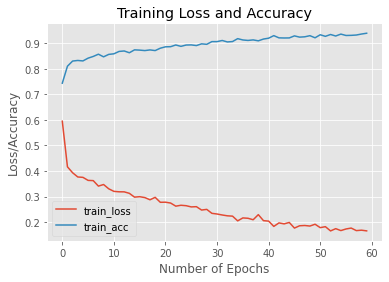

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0,  NUM_EPOCHS)
plt.style.use("ggplot")
fig = plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

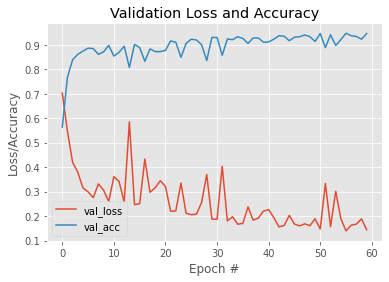

In [20]:
N = np.arange(0,  NUM_EPOCHS)
plt.style.use("ggplot")
fig = plt.figure()
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

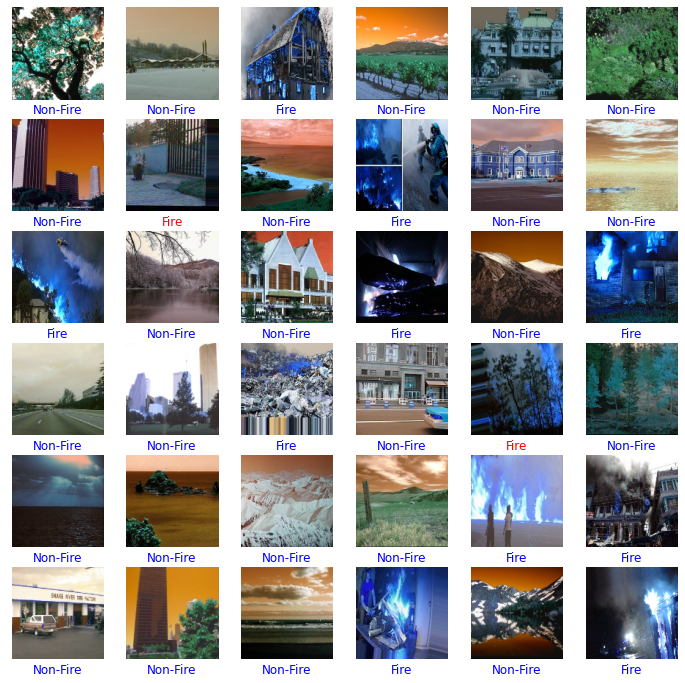

In [21]:
plt.figure(figsize=(12,12))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i], cmap=plt.cm.binary)
    if testY[i][0] == 1:
      if predictions[i][0] > 0.5:
        plt.xlabel("Non-Fire", color='blue')
      else:
        plt.xlabel("Non-Fire", color='red')
    else:
      if predictions[i][1] > 0.5:
        plt.xlabel("Fire", color='blue')
      else:
        plt.xlabel("Fire", color='red')

plt.show()

# **Model Summary**

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 128, 128, 8)       179       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 8)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 64, 64, 16)        216       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        6

# **Reference**

https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

# **Insights and Improvements**

An accuracy of 94 percent via a larger dataset, more training examples and an increase in number of epochs. Applying Data Augmentation and using Deep layers get better learn the features. By adding 1 more Convolutional layer, the model gives a fluctuation of accuracy between 94 and 95 percent. Dropout has been used to avoid overfitting.